In [1]:
import pygmt
import pygplates
import rioxarray
import numpy as np
import xarray as xr

from scripts import isinside

# Creating the forcing conditions for regional goSPL model

## Open eTopo

For this specific model, we will use the eTOPO dataset (`0.1 degrees` resolution) as the initial surface and modify it to account for some of the forcing (tectonic, sediment accumulation) that occured since the Miocene. 

Note that one other approach would have been to start with an initial paleo-elevation such as the Scotese paleo-surface model for the considered simulation starting time.

In [2]:
dataset = xr.open_dataset('inputs/etopo/ETOPO1_Bed_c_gmt4_0.00Ma.nc')
dataset

<xarray.Dataset>
Dimensions:  (lat: 1801, lon: 3601)
Coordinates:
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    crs      |S1 ...
    Band1    (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.2.4, released 2018/03/19
    history:      Tue Sep 28 16:01:18 2021: GDAL CreateCopy( /Users/clairemal...

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline


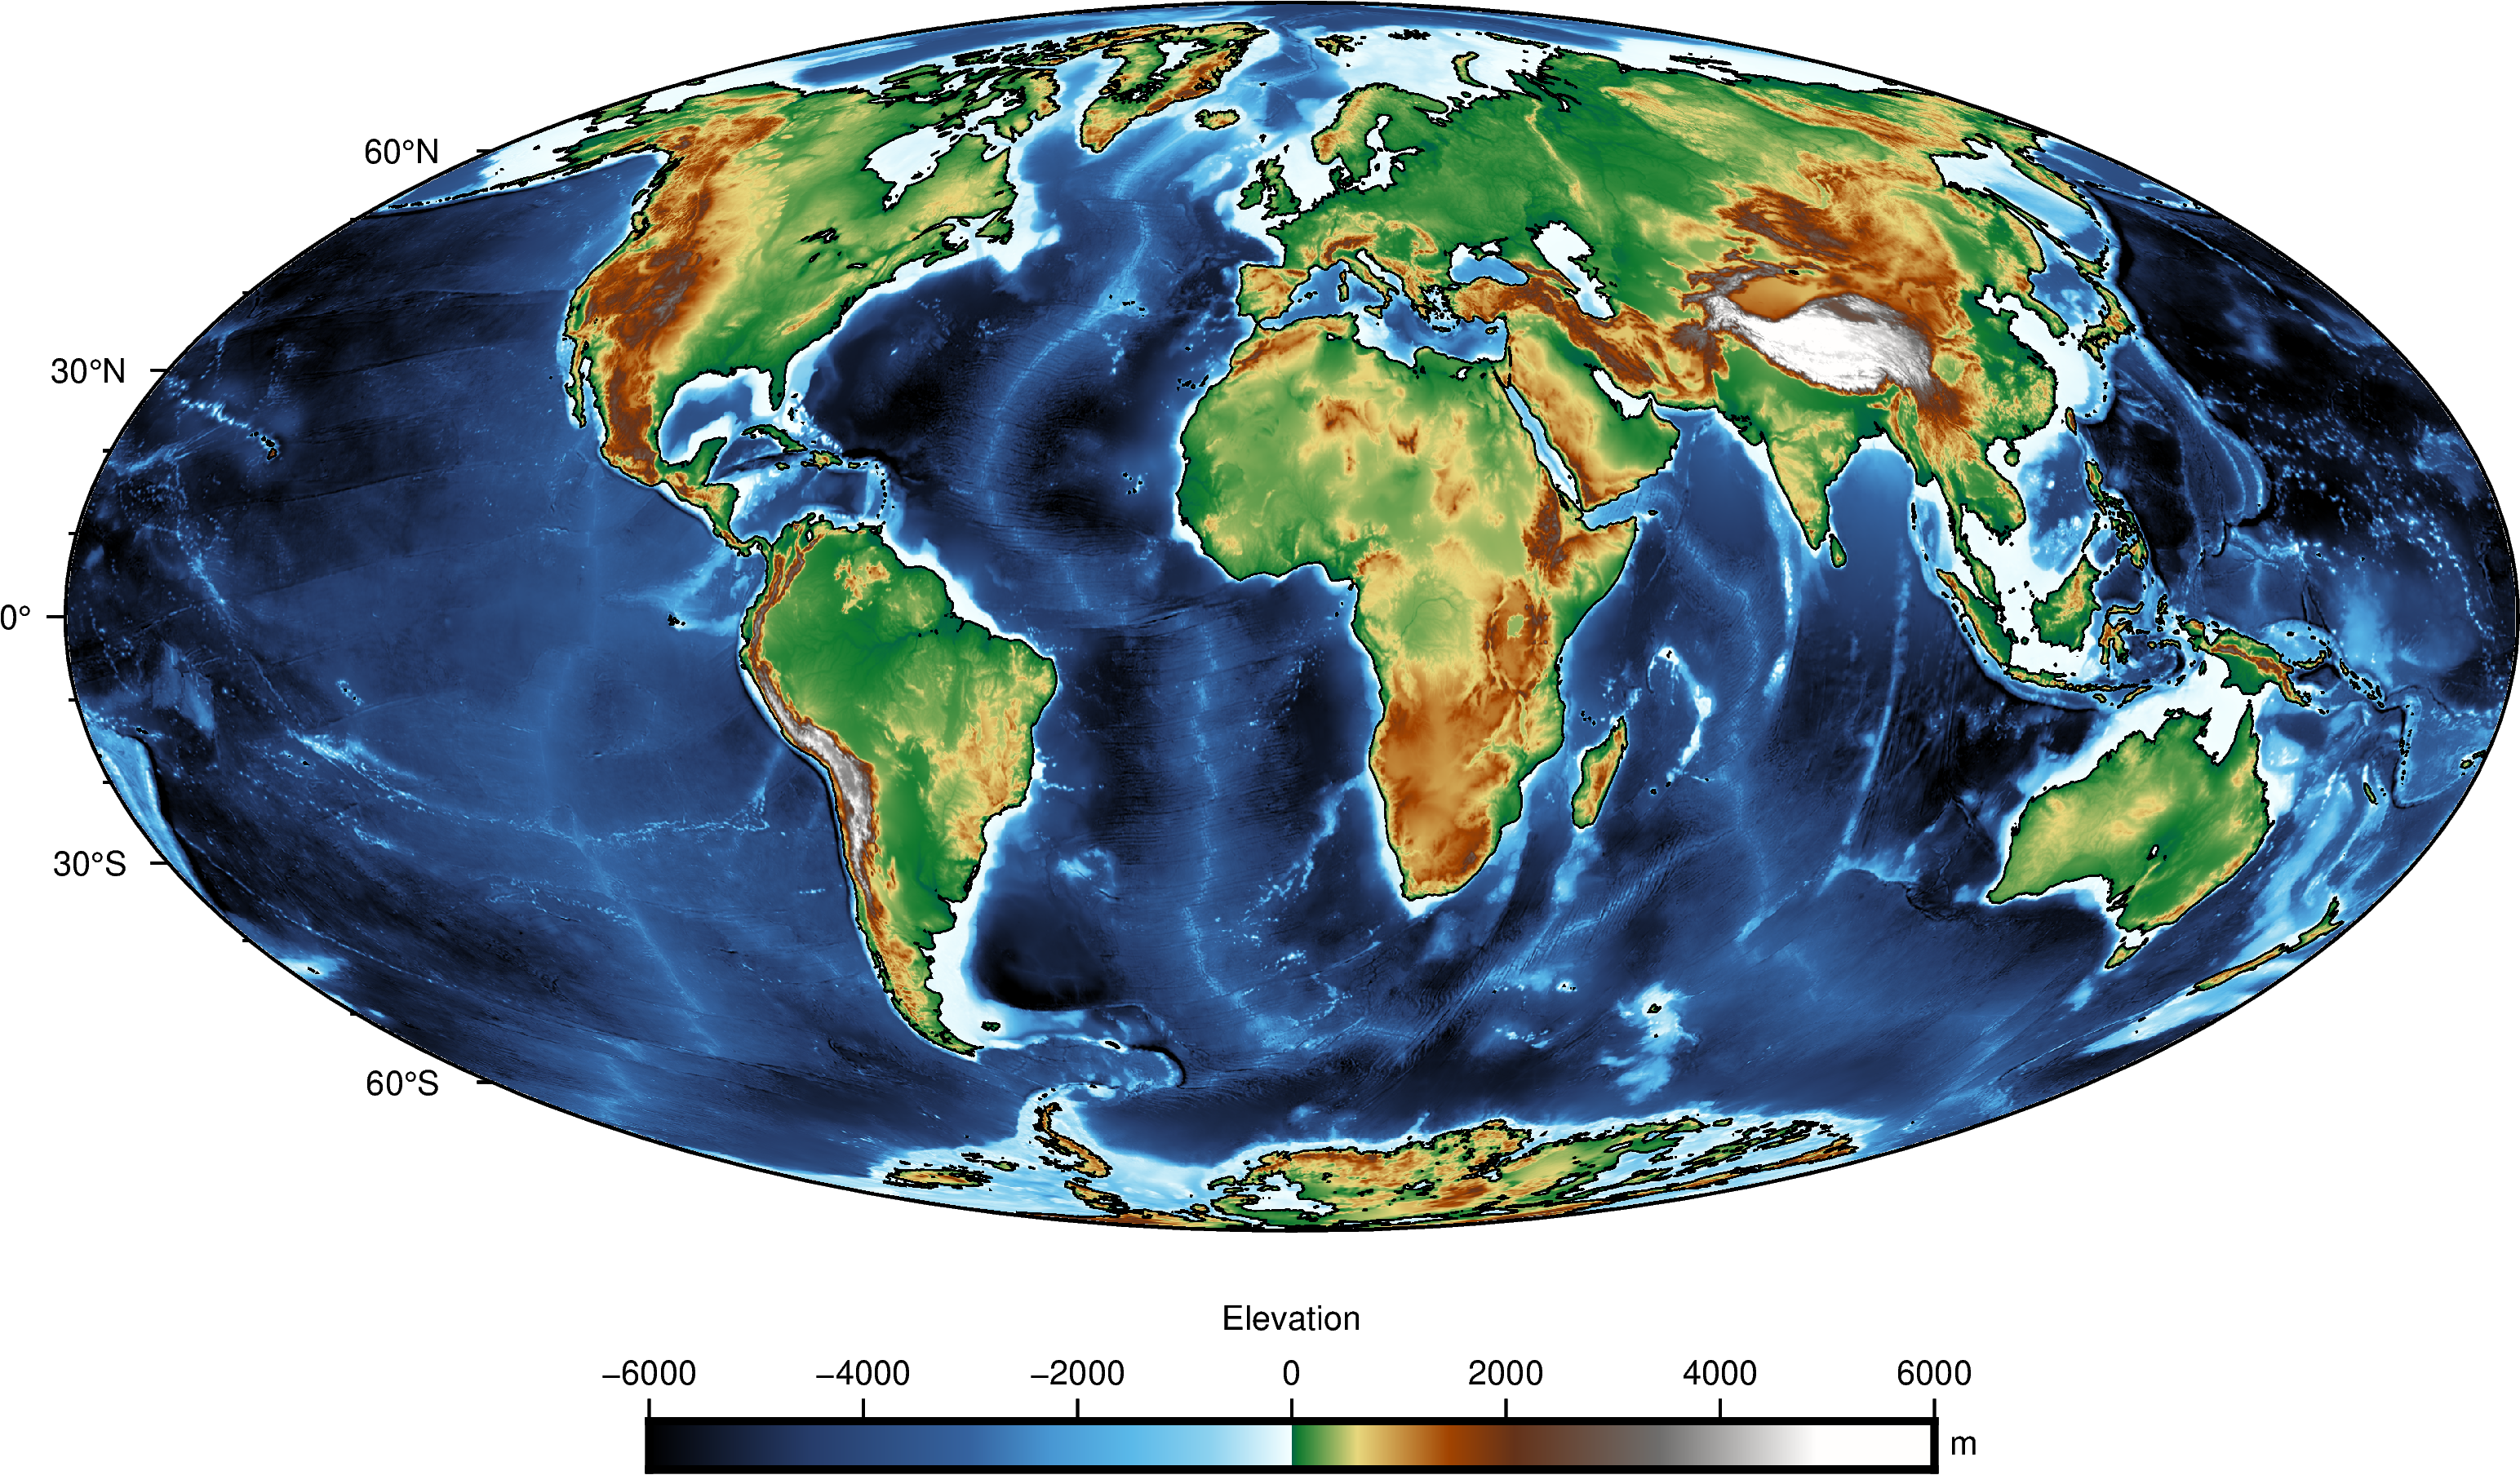

In [3]:
elevation = dataset.Band1
fig = pygmt.Figure()
with pygmt.config(FONT='6p,Helvetica,black'):
    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.grdimage(elevation, shading='+a345+nt1+m0', frame=False)
    fig.grdcontour(
        interval=0.1,
        grid=elevation,
        limit=[-0.1, 0.1],
    )
    fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h",frame=["a2000", "x+lElevation", "y+lm"])
fig.show(dpi=500, width=1000)

## Read Dynamic Topography 

You can find and download dynamic topogaphy rasters in http://portal.gplates.org/portal/dt/. Once downloaded you will then need to open it in `gPlates` and extract the dynamic topography at `0.1` degrees resolution and at `1 Ma` interval also fixing the reference plate to North America (`plate ID 102`). 

In [4]:
for k in range(17):
    dtfiles = 'inputs/DynamicTopography/Interpolated-Y17_'+str(k)+'.00Ma.nc'
    ds = xr.open_dataset(dtfiles)
    dtvals = ds.Band1.values
    dataset["DT"+str(int(k))+"Ma"]=(['lat', 'lon'],  np.nan_to_num(dtvals, copy=True, nan=0.0))

grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline


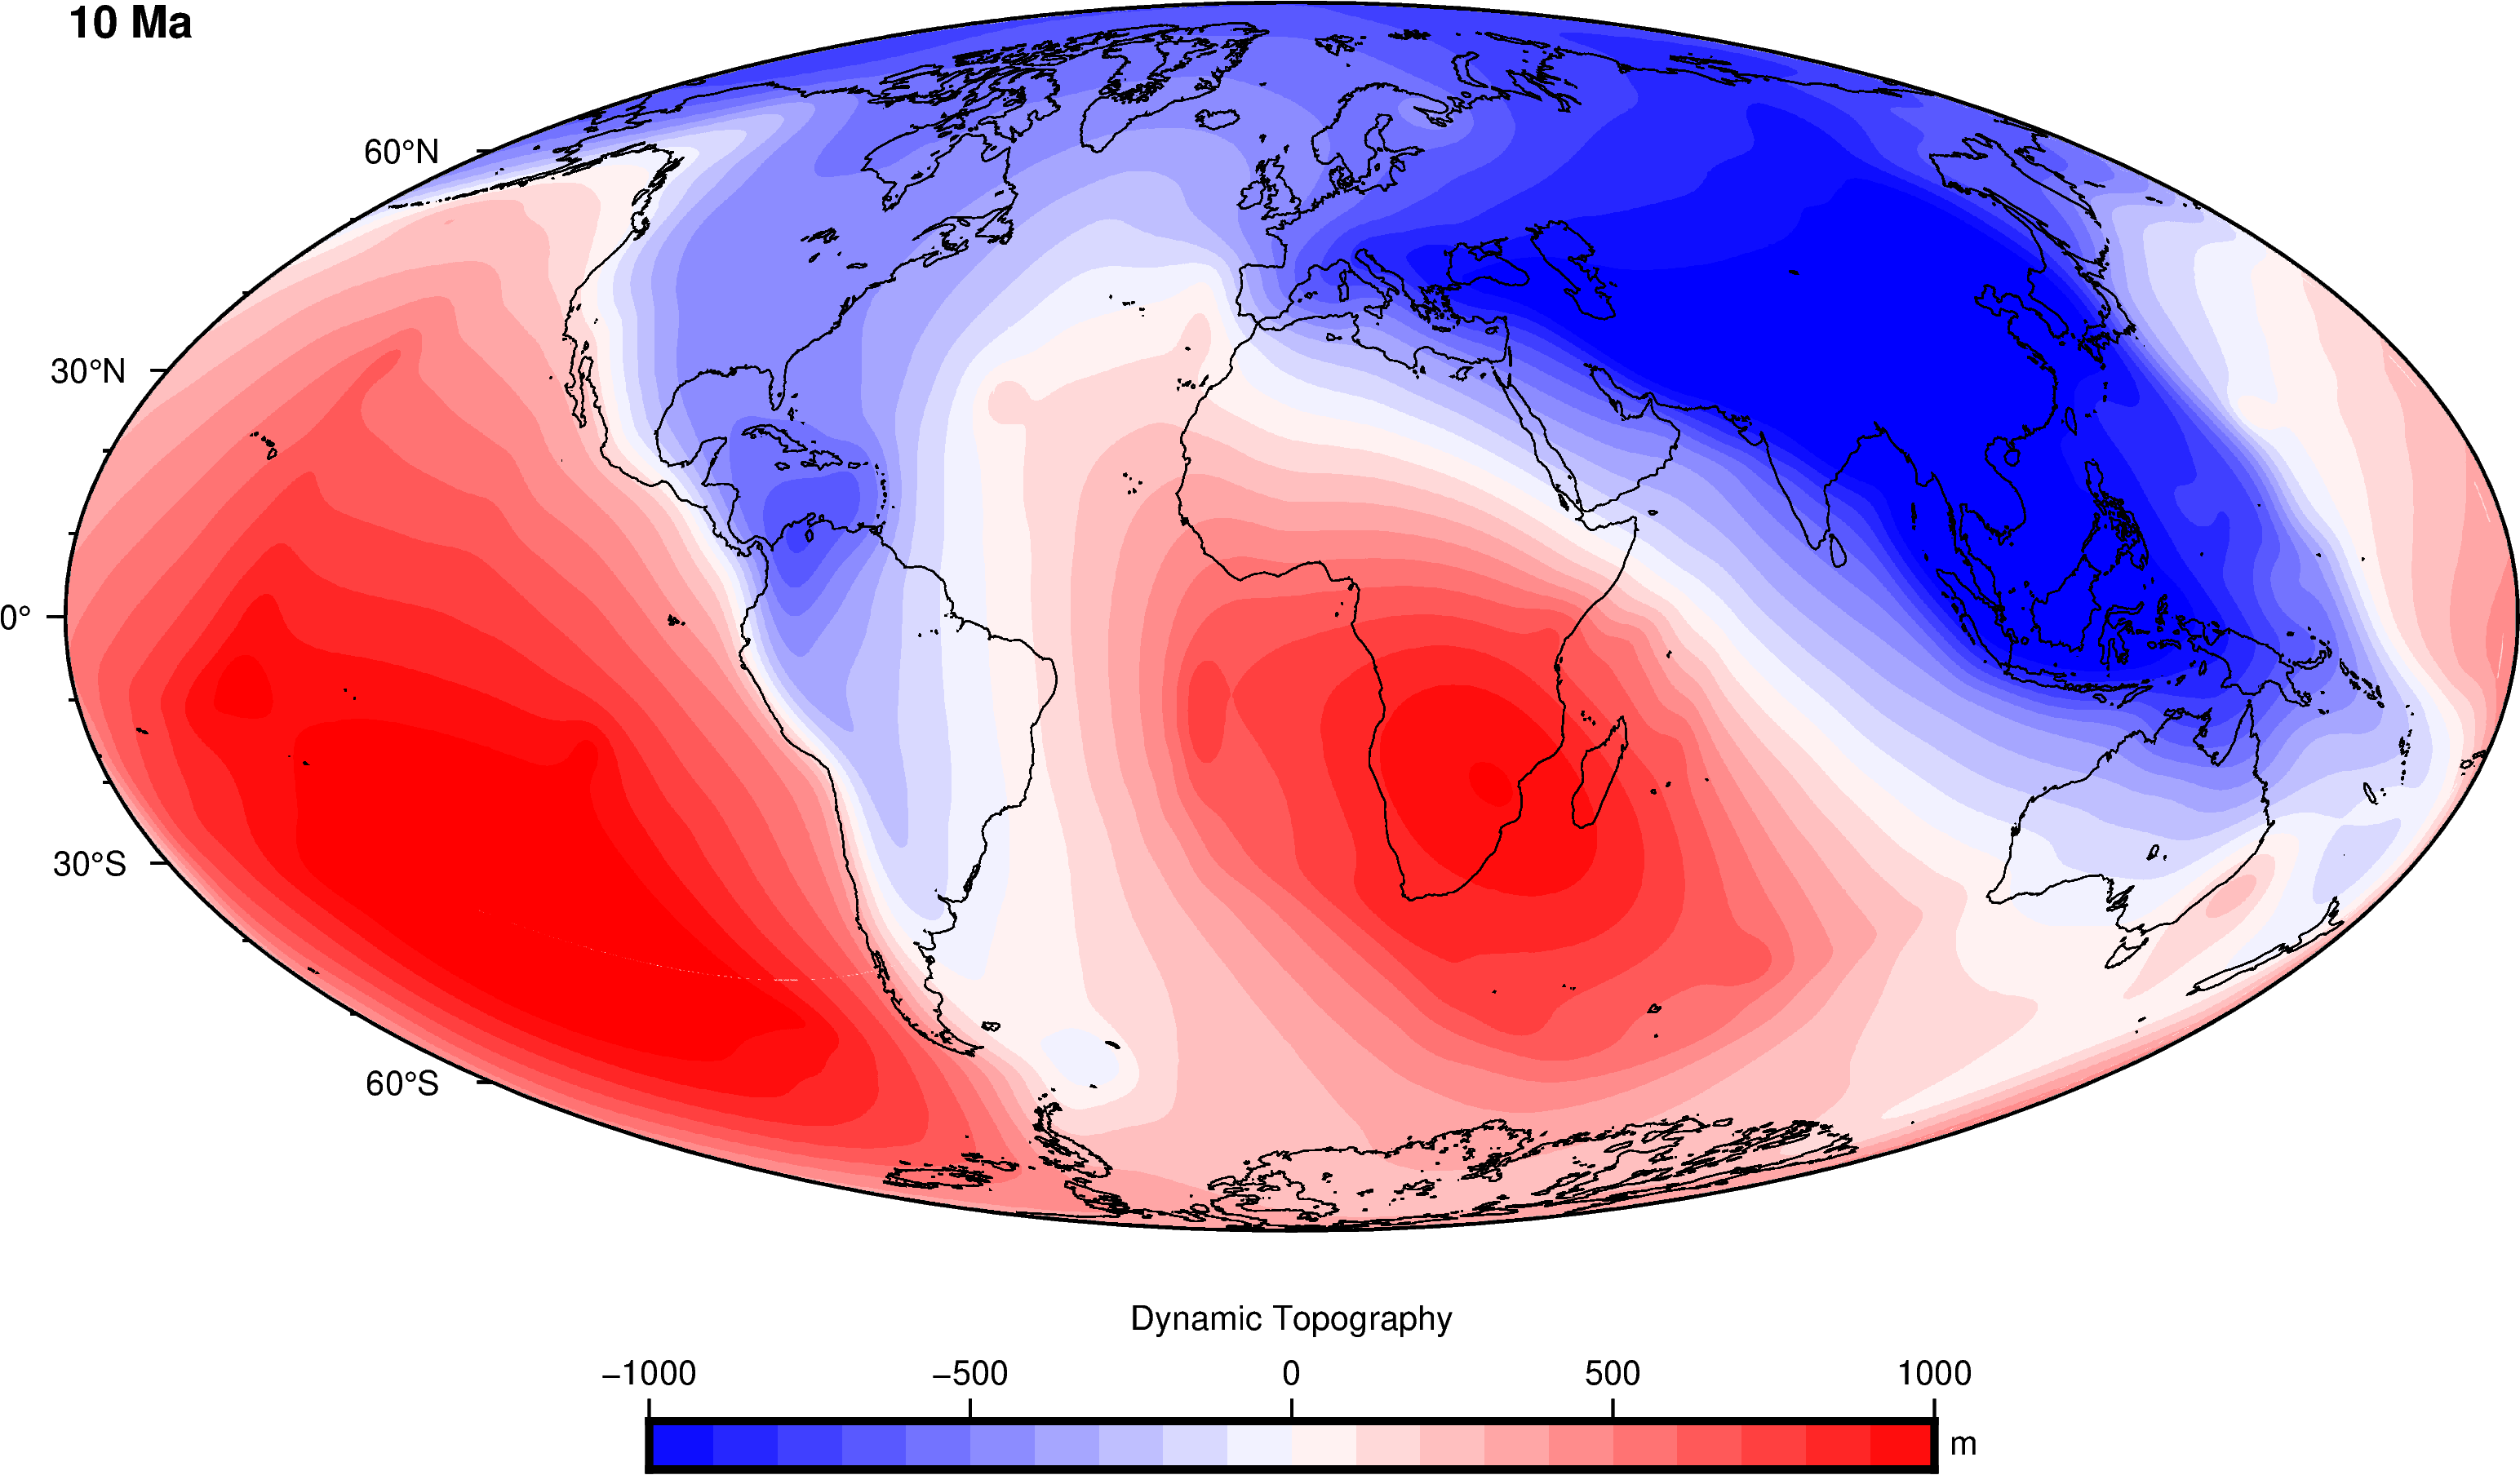

In [5]:
step = 10
elevation = dataset.Band1
fig = pygmt.Figure()
with pygmt.config(FONT='6p,Helvetica,black', COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="polar", series=[-1000,1000, 100])
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.grdimage(dataset["DT"+str(int(step))+"Ma"], shading='+a345+nt1+m0', frame=False)
    fig.grdcontour(
        interval=0.1,
        grid=elevation,
        limit=[-0.1, 0.1],
    )
    fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h",frame=["a500", 'x+l"Dynamic Topography"', "y+lm"])
fig.text(text=str(step)+" Ma", position="TL", font="8p,Helvetica-Bold,black") #, xshift="-0.75c")
fig.show(dpi=500, width=1000)

## Moving to a regional model


We will now clip the dataset to our region of interest:

+ `llcrnrlon = -120` - Lower left corner longitude
+ `llcrnrlat = 15`   - Lower left corner latitude
+ `urcrnrlon = -71`  - Upper right corner longitude
+ `urcrnrlat = 45`   - Upper right corner latitude

In [6]:
region = [-120,-71,15,45]

dataset.rio.write_crs("epsg:4326", inplace=True)
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [region[0], region[2]],
            [region[1], region[2]],
            [region[1], region[3]],
            [region[0], region[3]]
        ]]
    }
]
ds = dataset.rio.clip(geometries)

clipped = xr.Dataset({
    'elevation': xr.DataArray(
                data   = ds.Band1.values,   # enter data here
                dims   = ['lat','lon'],
                coords = {'lon': ds.lon.values, 'lat':ds.lat.values},
                ),
            },
    )
for k in range(17):
    clipped["DT"+str(int(k))+"Ma"] = ds["DT"+str(int(k))+"Ma"]
clipped = clipped.drop(['crs','spatial_ref'])

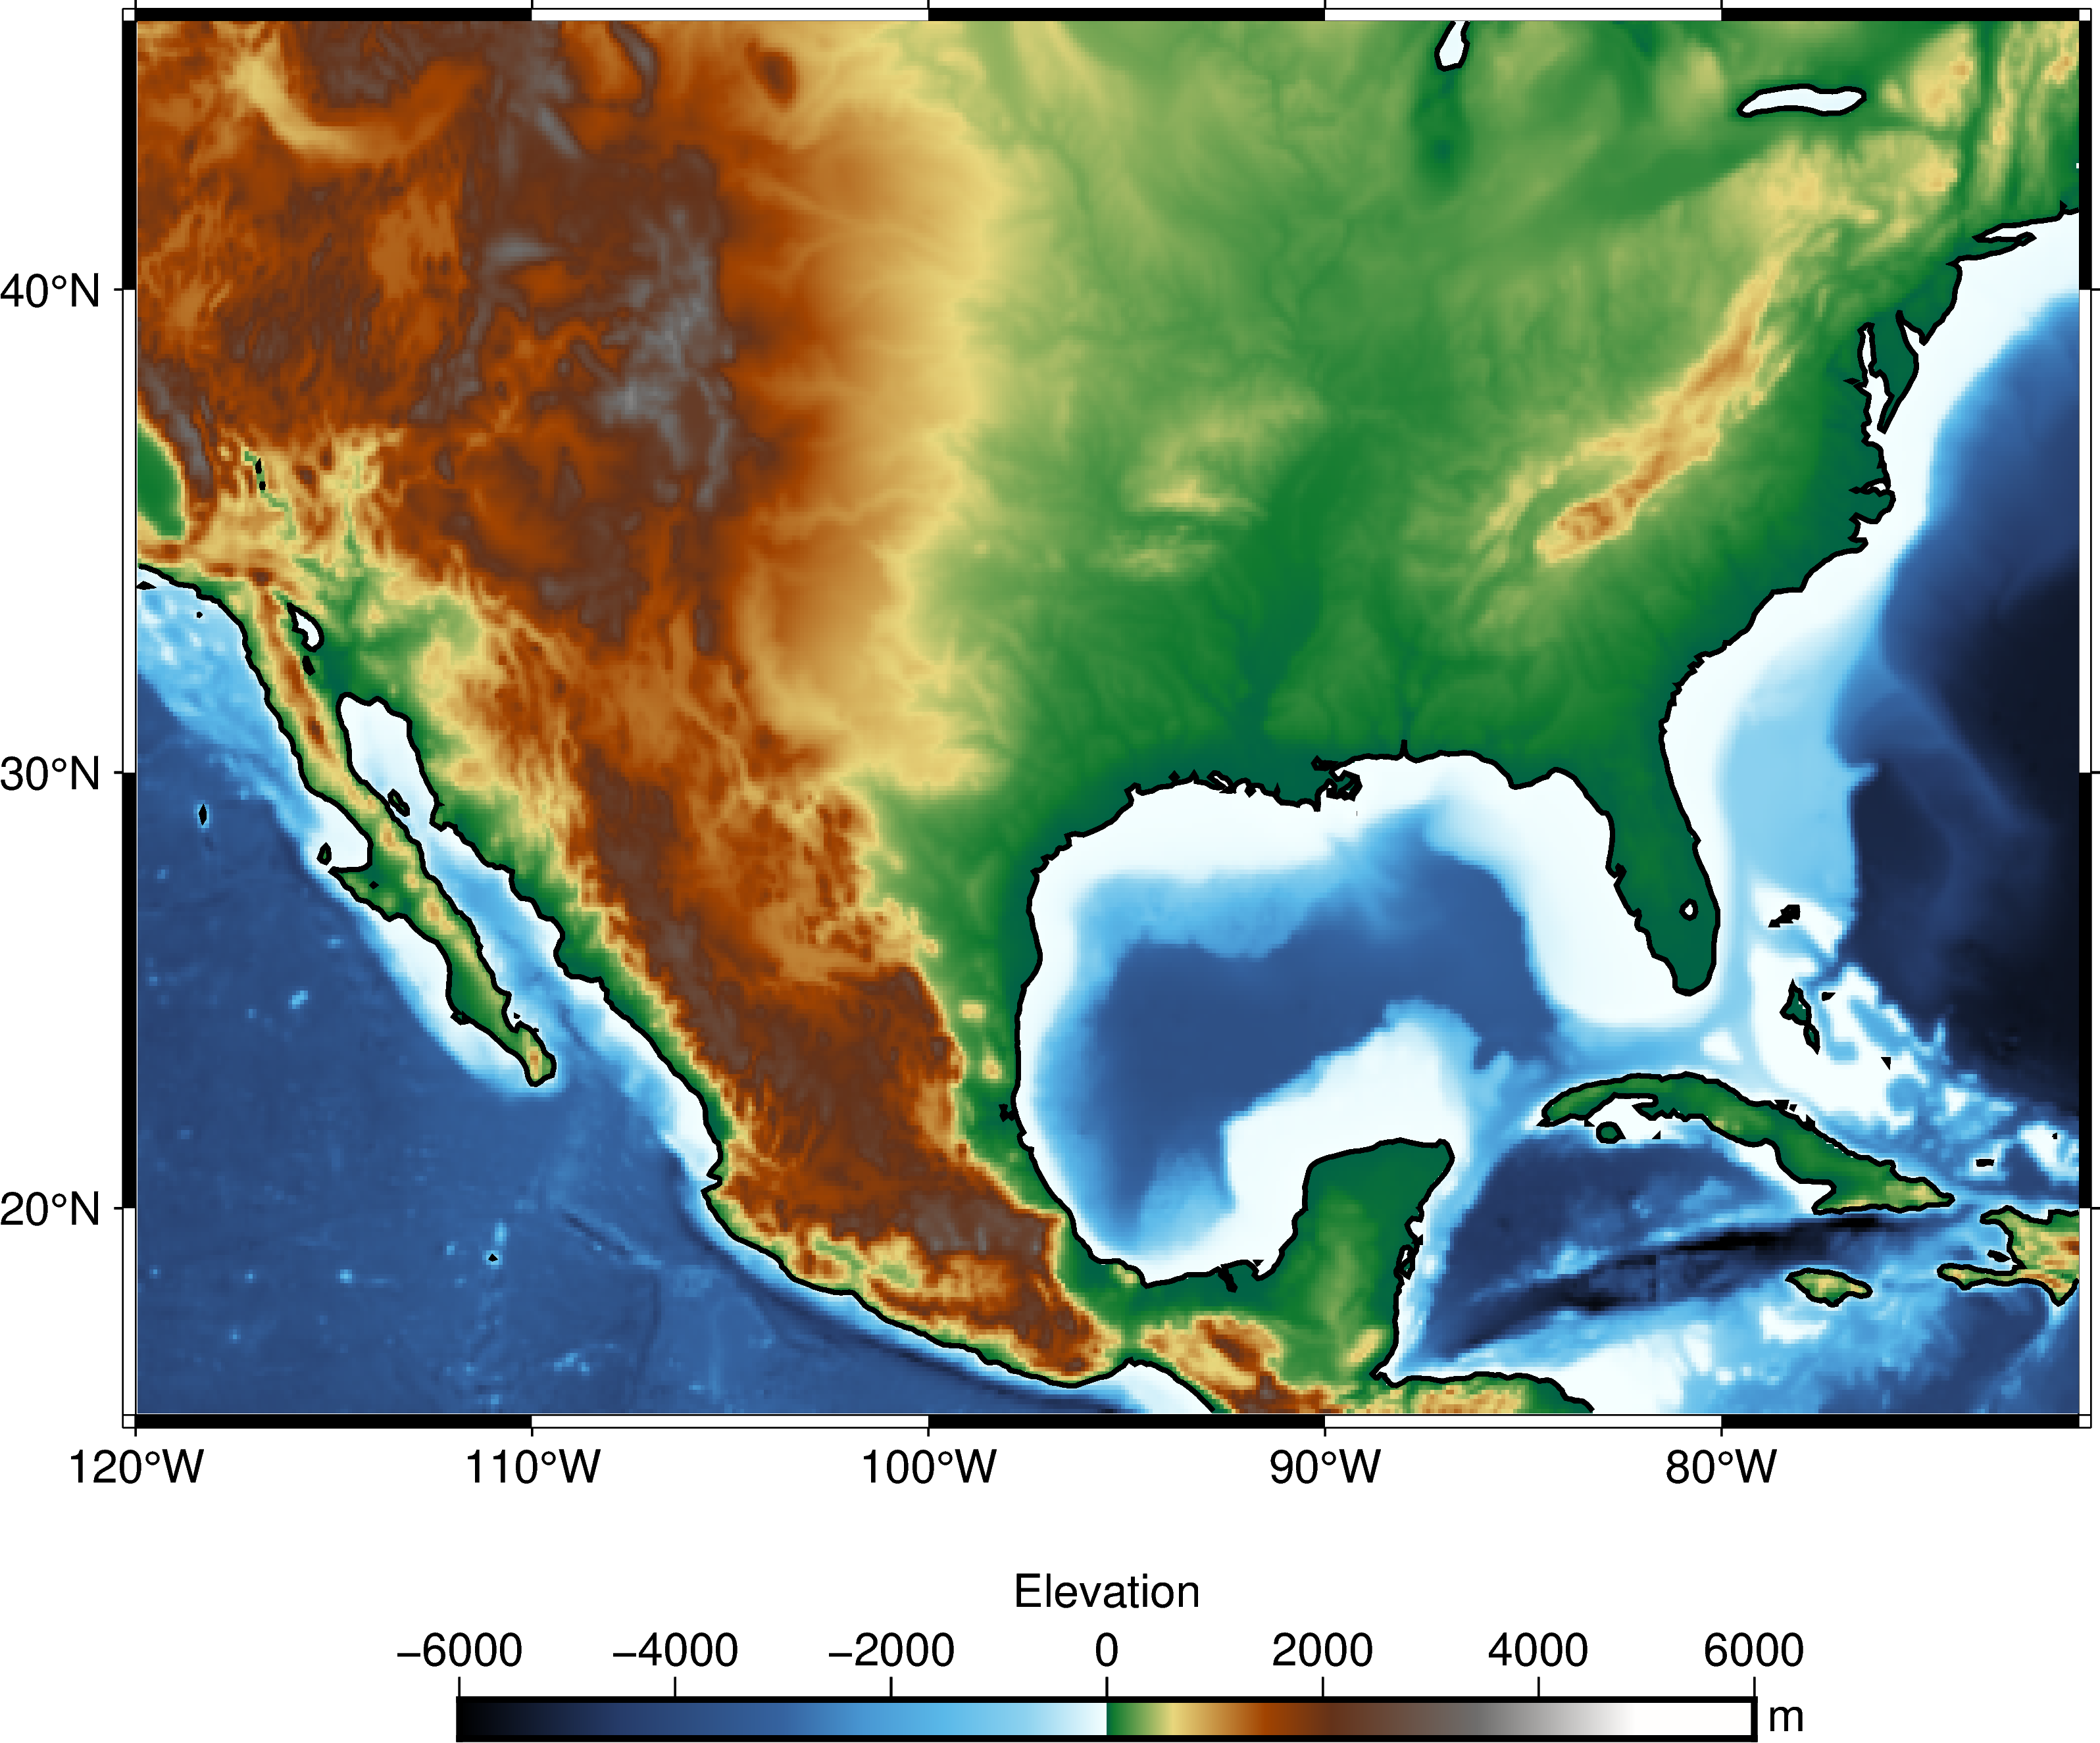

In [7]:
fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black'):
    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    fig.basemap(region=region, projection='M15c', frame='a')    
    fig.grdimage(clipped.elevation, 
                 shading=False, 
                 frame=False)
    fig.grdcontour(
        interval=0.1,
        grid=clipped.elevation,
        limit=[-0.1, 0.1],
        pen='1.p'
    )
    fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
fig.show(dpi=500, width=600)

Let us define the coordinates

In [8]:
glat = clipped.lat.values
glon = clipped.lon.values
glon, glat = np.meshgrid(clipped.lon.values,clipped.lat.values)
points = np.stack((glon.ravel(), glat.ravel())).T
clipshape = glon.shape

## Sediment accumulation 

Here sediment accumulation contours are provided thanks to a Gplates `gpml` file that defines for each contour the accumulation thickness in its name. 

We extract both the coordinates and the thicknesses separately.

### Cumulative thicknesses deposited during the mid Miocene

We will build an accumulation map based on these contours:

In [10]:
fname = "inputs/GPlates/contours_midMiocene.gpml"
lonlat, val = isinside.dataGPML(fname, key="feet")

# Then we find the values of the accumulated sediment based on the contours lines
# In this specific case accumulation are given in feets so we change it to metres (1 feet = 0.3048 m)
accuSed = isinside.contour2map(points, lonlat, val*0.3048, clipshape, sigma=2)

# Let's store it in the xarray dataset
clipped["accuSedMio"]=(['lat', 'lon'],  accuSed)

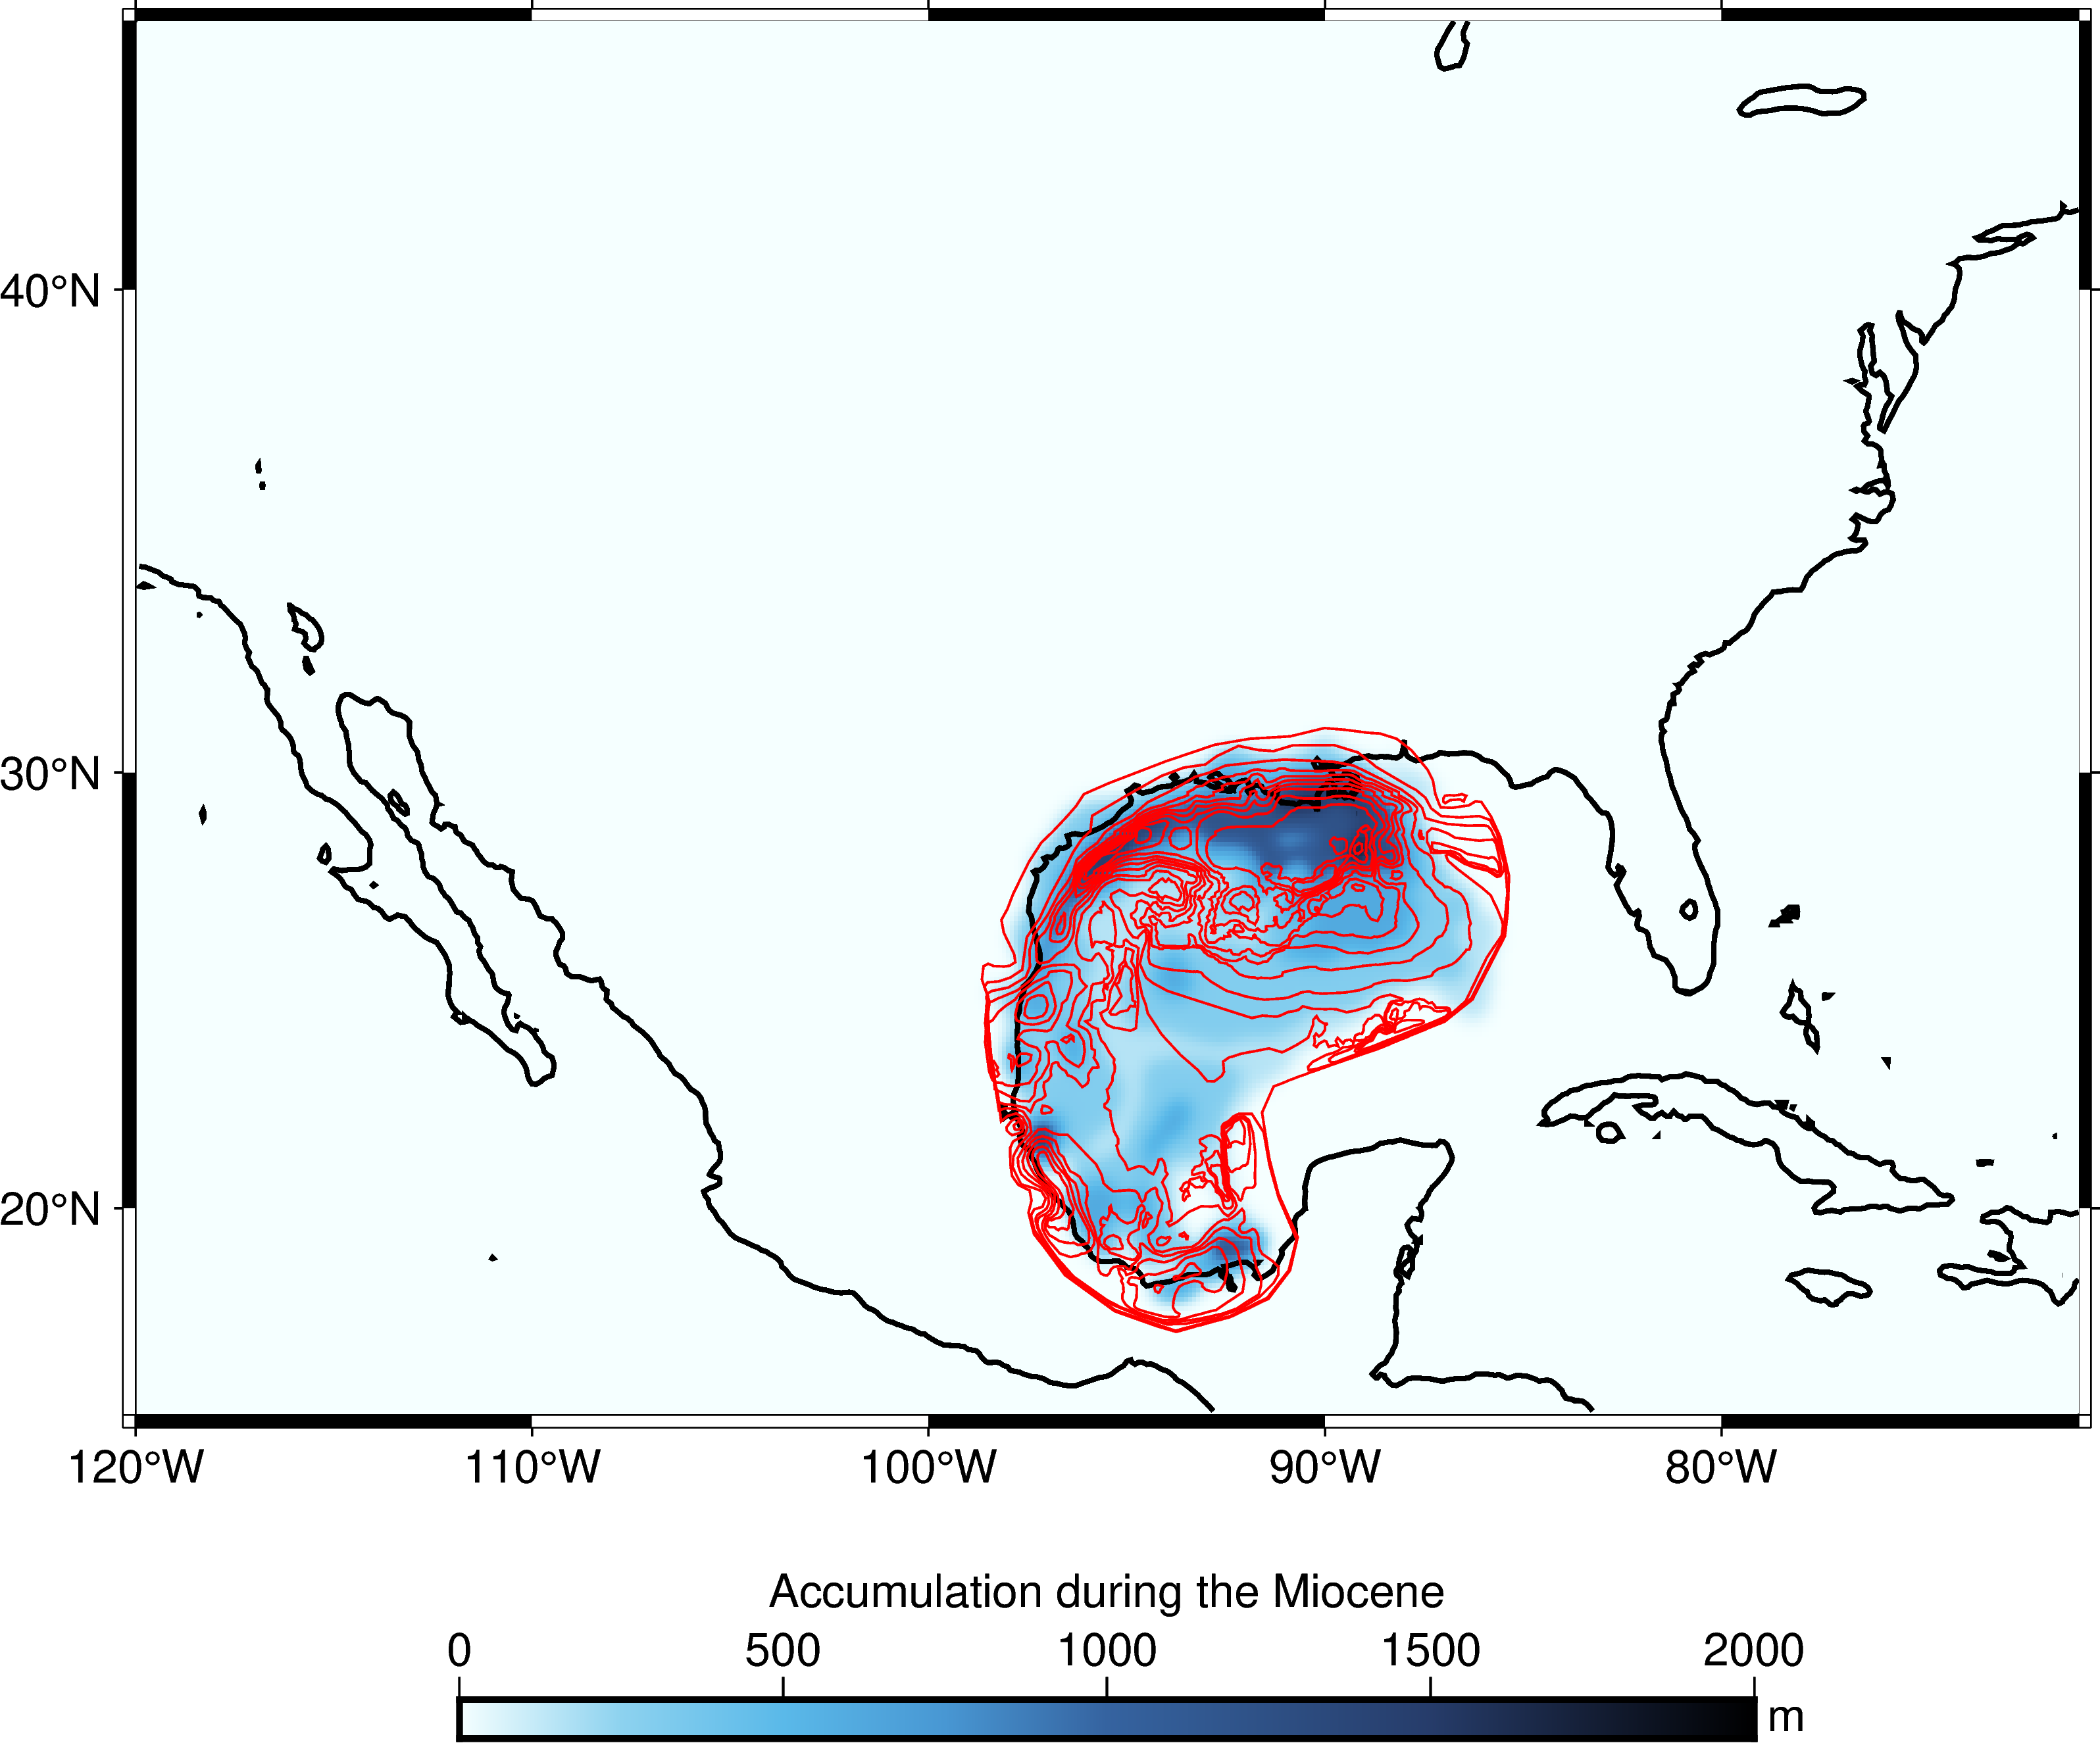

In [20]:
fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black', COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="abyss", series=[0, 2000], reverse=True)
    fig.basemap(region=region, projection='M15c', frame='a')    
    fig.grdimage(clipped.accuSedMio, shading=False, frame=False)
    fig.grdcontour( interval=0.1, grid=clipped.elevation, limit=[-0.1, 0.1], pen='1.p')
    for k in range(len(lonlat)):
        fig.plot(x=lonlat[k][:,0], y=lonlat[k][:,1], pen="0.5p,red", )
    fig.colorbar(frame=["a500", 'x+l"Accumulation during the Miocene"', "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
fig.show(dpi=500, width=600)

### Cumulative thicknesses since the mid Miocene

We perform the same operation, this time we load the sediment accumulation since the mid Miocene.

In [21]:
fname = "inputs/GPlates/contours_midMio-0.gpml"
lonlat, val = isinside.dataGPML(fname, key="feet")

# Then we find the values of the accumulated sediment based on the contours lines
# In this specific case accumulation are given in feets so we change it to metres (1 feet = 0.3048 m)
accuTot = isinside.contour2map(points, lonlat, val*0.3048, clipshape, sigma=2)

# Let's store it in the xarray dataset
clipped["accuSed"]=(['lat', 'lon'],  accuTot)

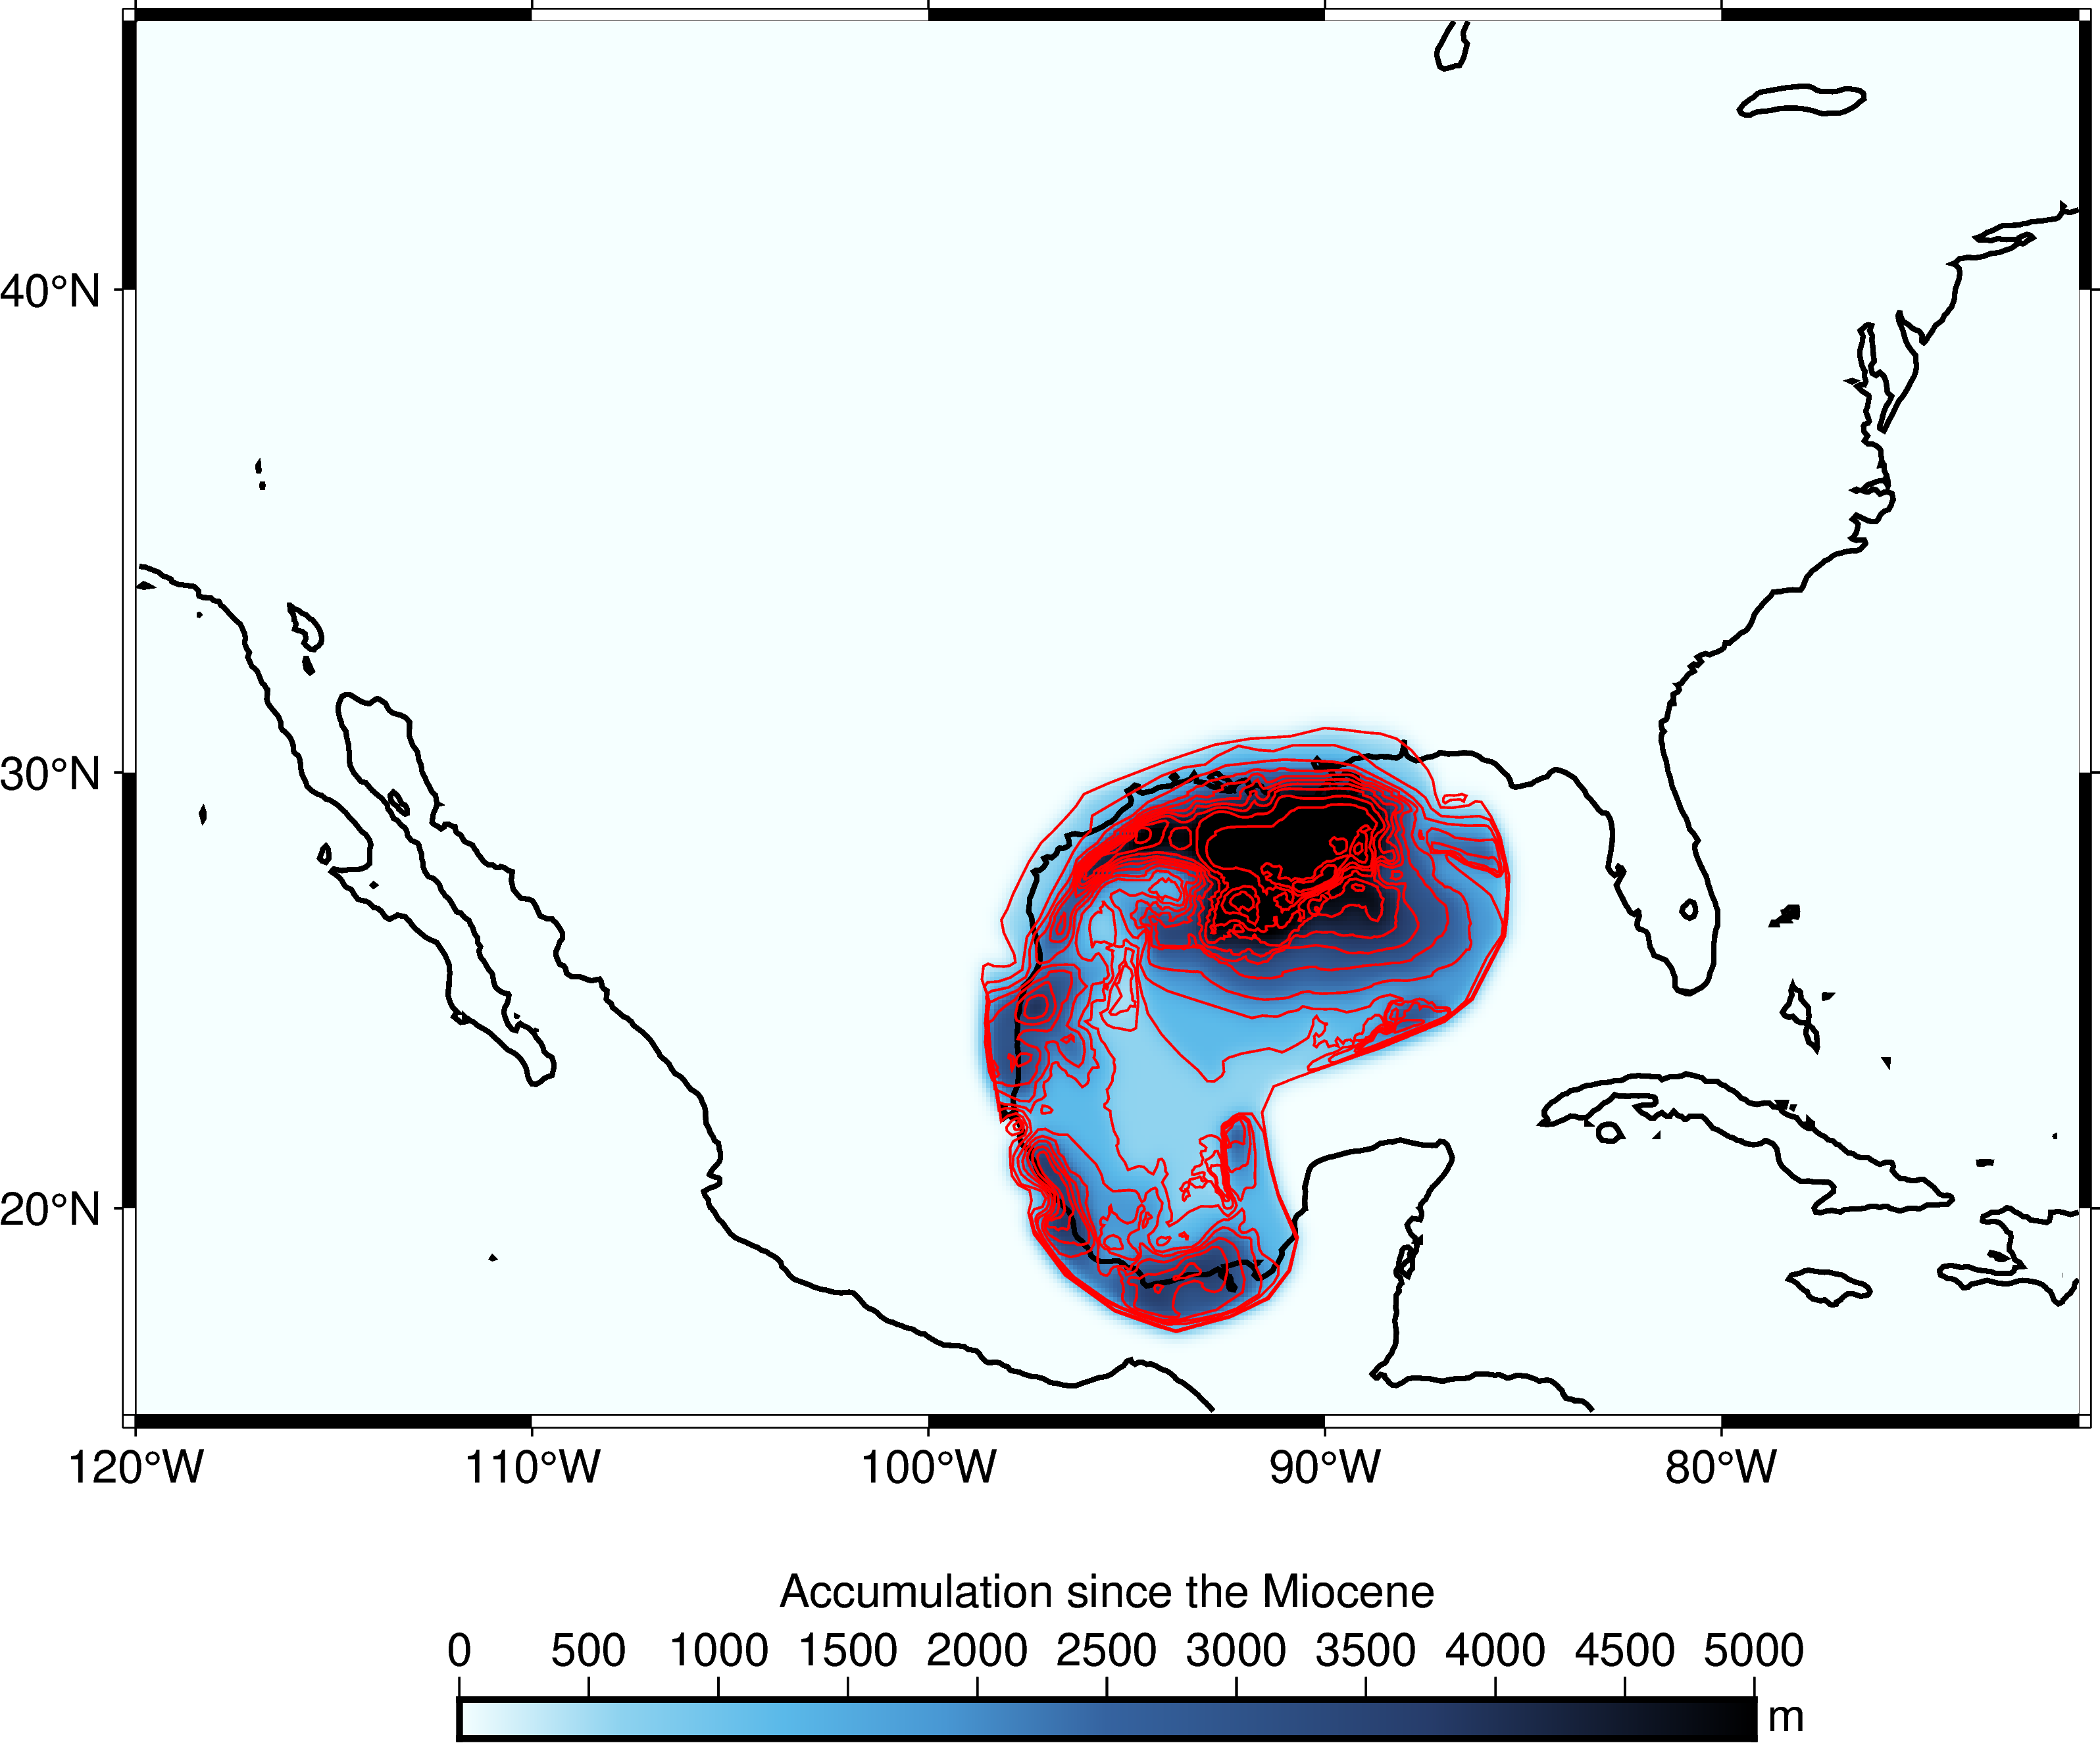

In [22]:
fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black', COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="abyss", series=[0, 5000], reverse=True)
    fig.basemap(region=region, projection='M15c', frame='a')    
    fig.grdimage(clipped.accuSed, shading=False, frame=False)
    fig.grdcontour( interval=0.1, grid=clipped.elevation, limit=[-0.1, 0.1], pen='1.p')
    for k in range(len(lonlat)):
        fig.plot(x=lonlat[k][:,0], y=lonlat[k][:,1], pen="0.5p,red", )
    fig.colorbar(frame=["a500", 'x+l"Accumulation since the Miocene"', "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
fig.show(dpi=500, width=600)

## Tectonics

Assuming you have defined some tectonic polygons as `gpml` files in GPlates to represent vertical movement (uplift and subsidence) induced by crustal deformation, we can map these forces on the regional domain:

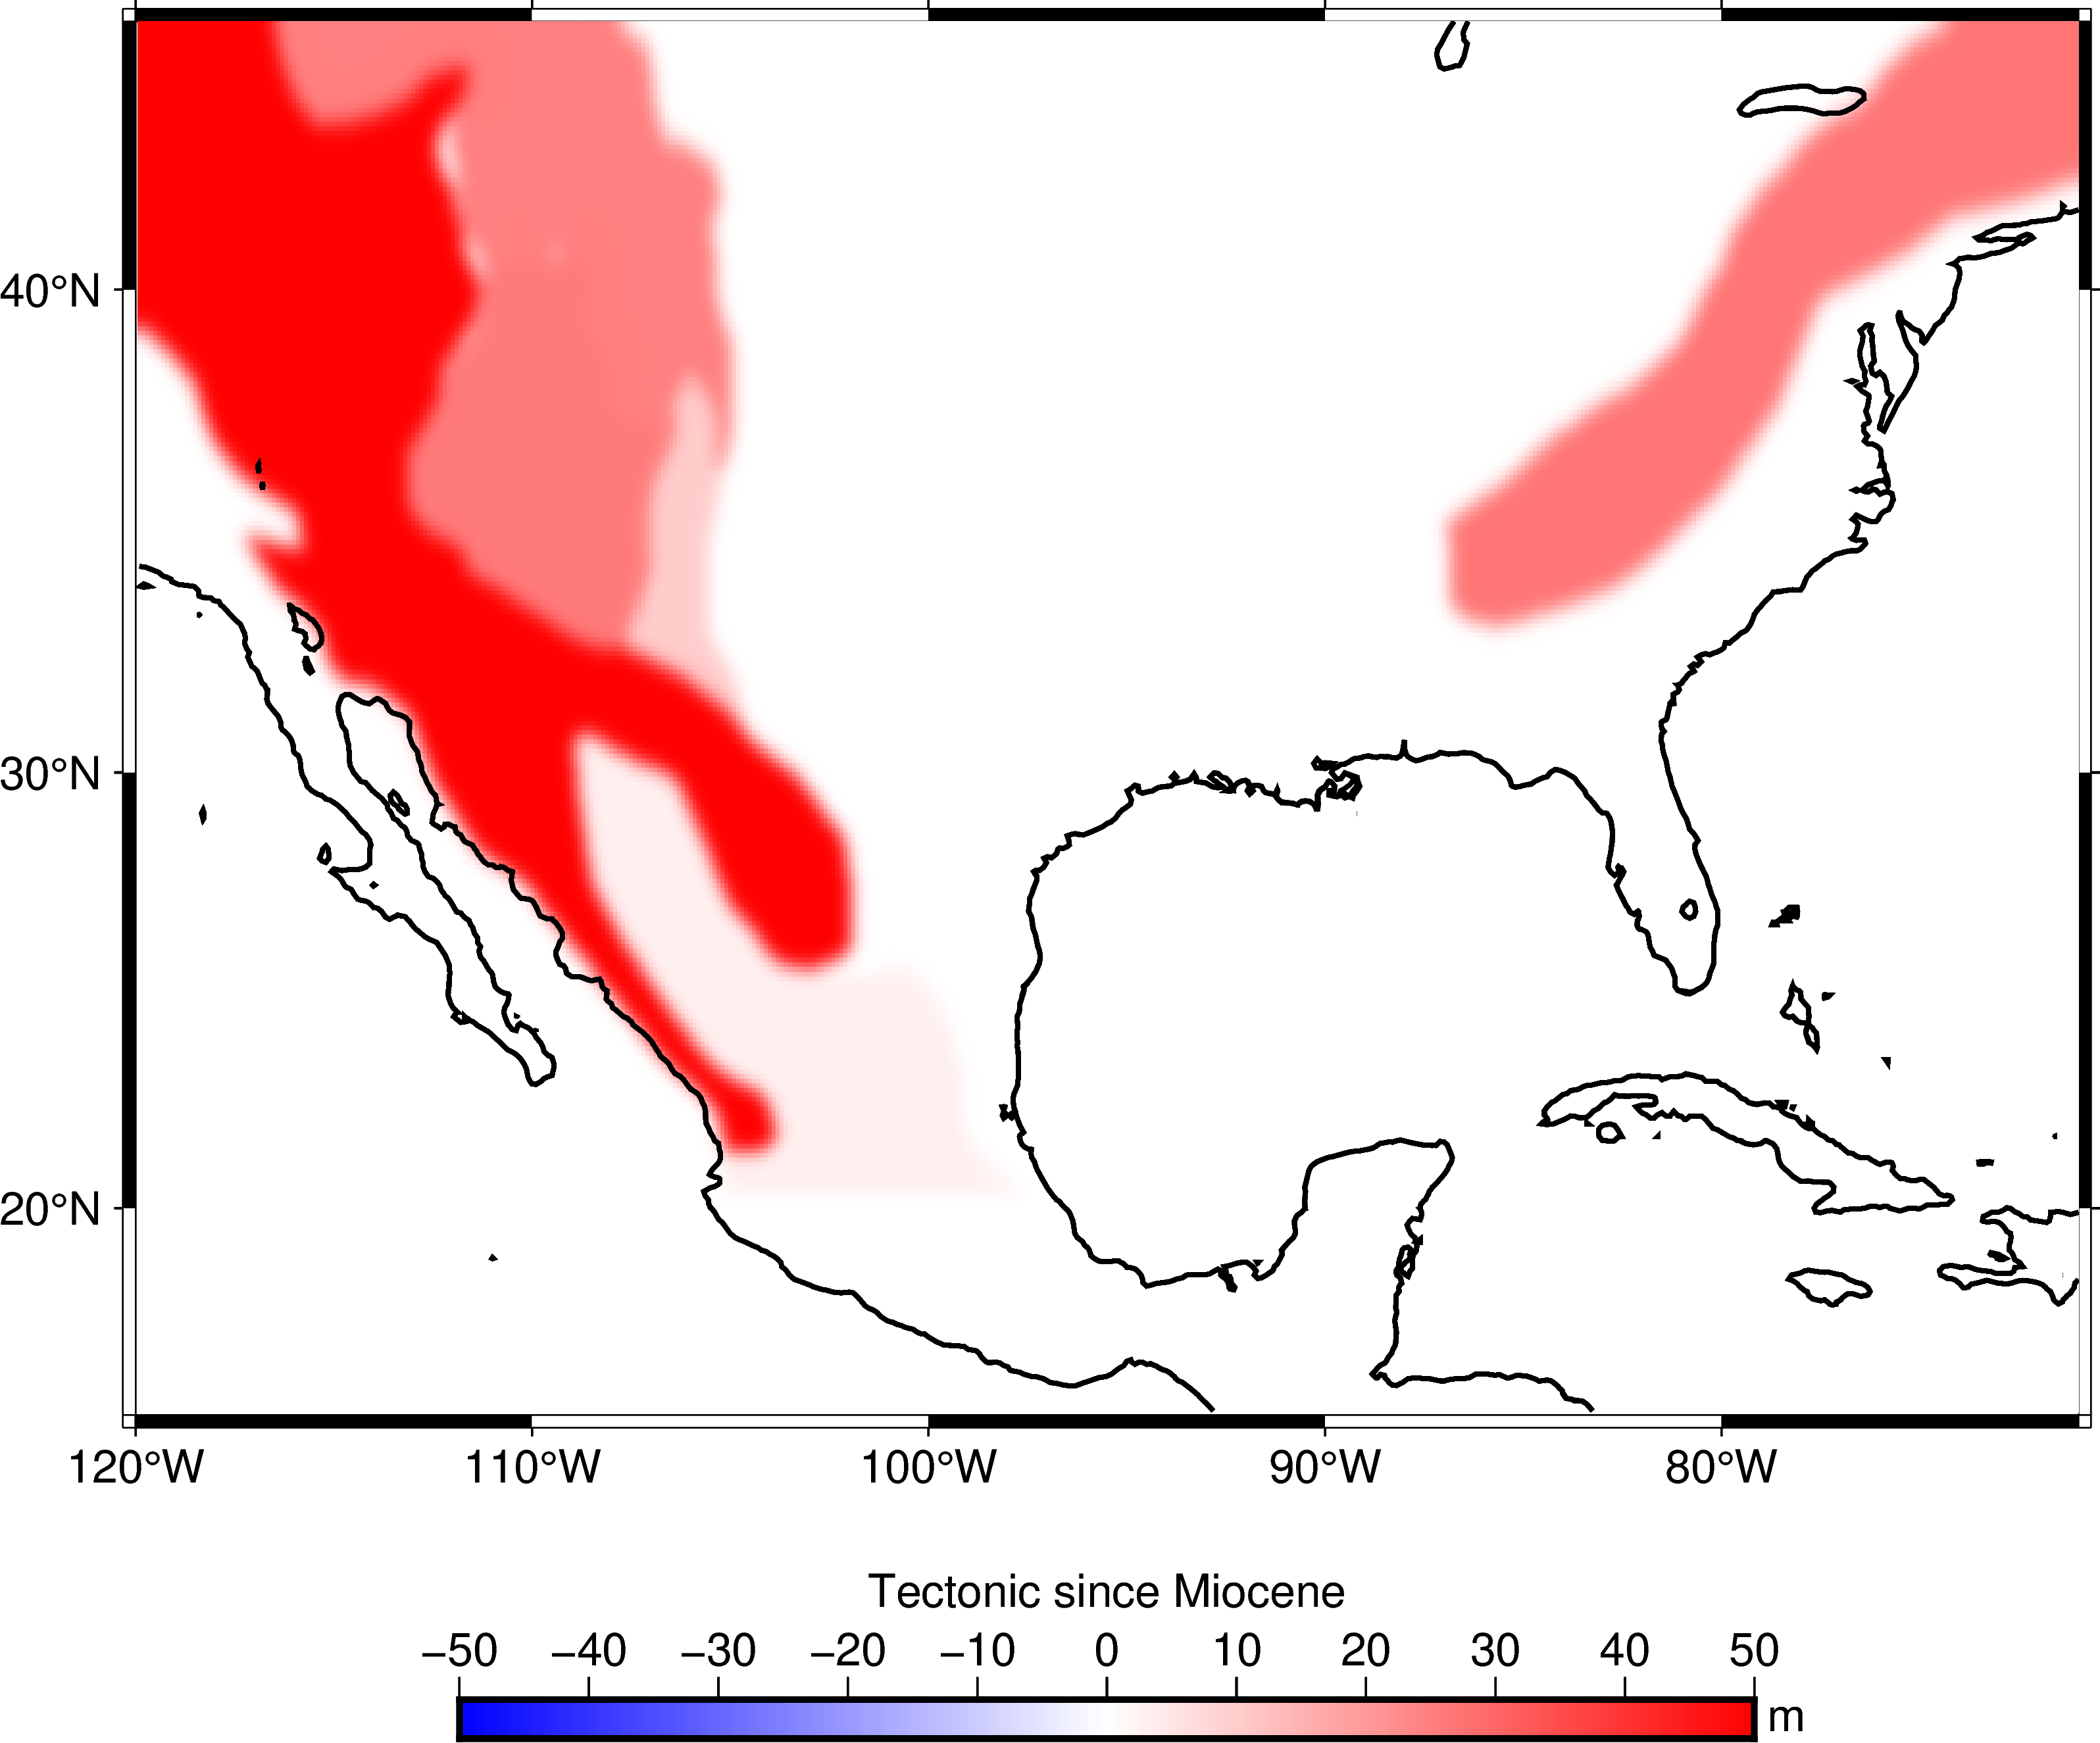

In [13]:
fname = "inputs/GPlates/tectonic.gpml"
lonlat, val = isinside.dataGPML(fname, key="m")
tec = isinside.contour2map(points, lonlat, val, clipshape, sigma=2)

# Let's store it in the xarray dataset
clipped["tectonic"]=(['lat', 'lon'],  tec)

fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black', COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="polar", series=[-50, 50])
    fig.basemap(region=region, projection='M15c', frame='a')    
    fig.grdimage(clipped.tectonic, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=clipped.elevation, limit=[-0.1, 0.1], pen='1.p')
    fig.colorbar(frame=["a10", 'x+l"Tectonic since Miocene"', "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
fig.show(dpi=500, width=600)

## Topographic readjustement

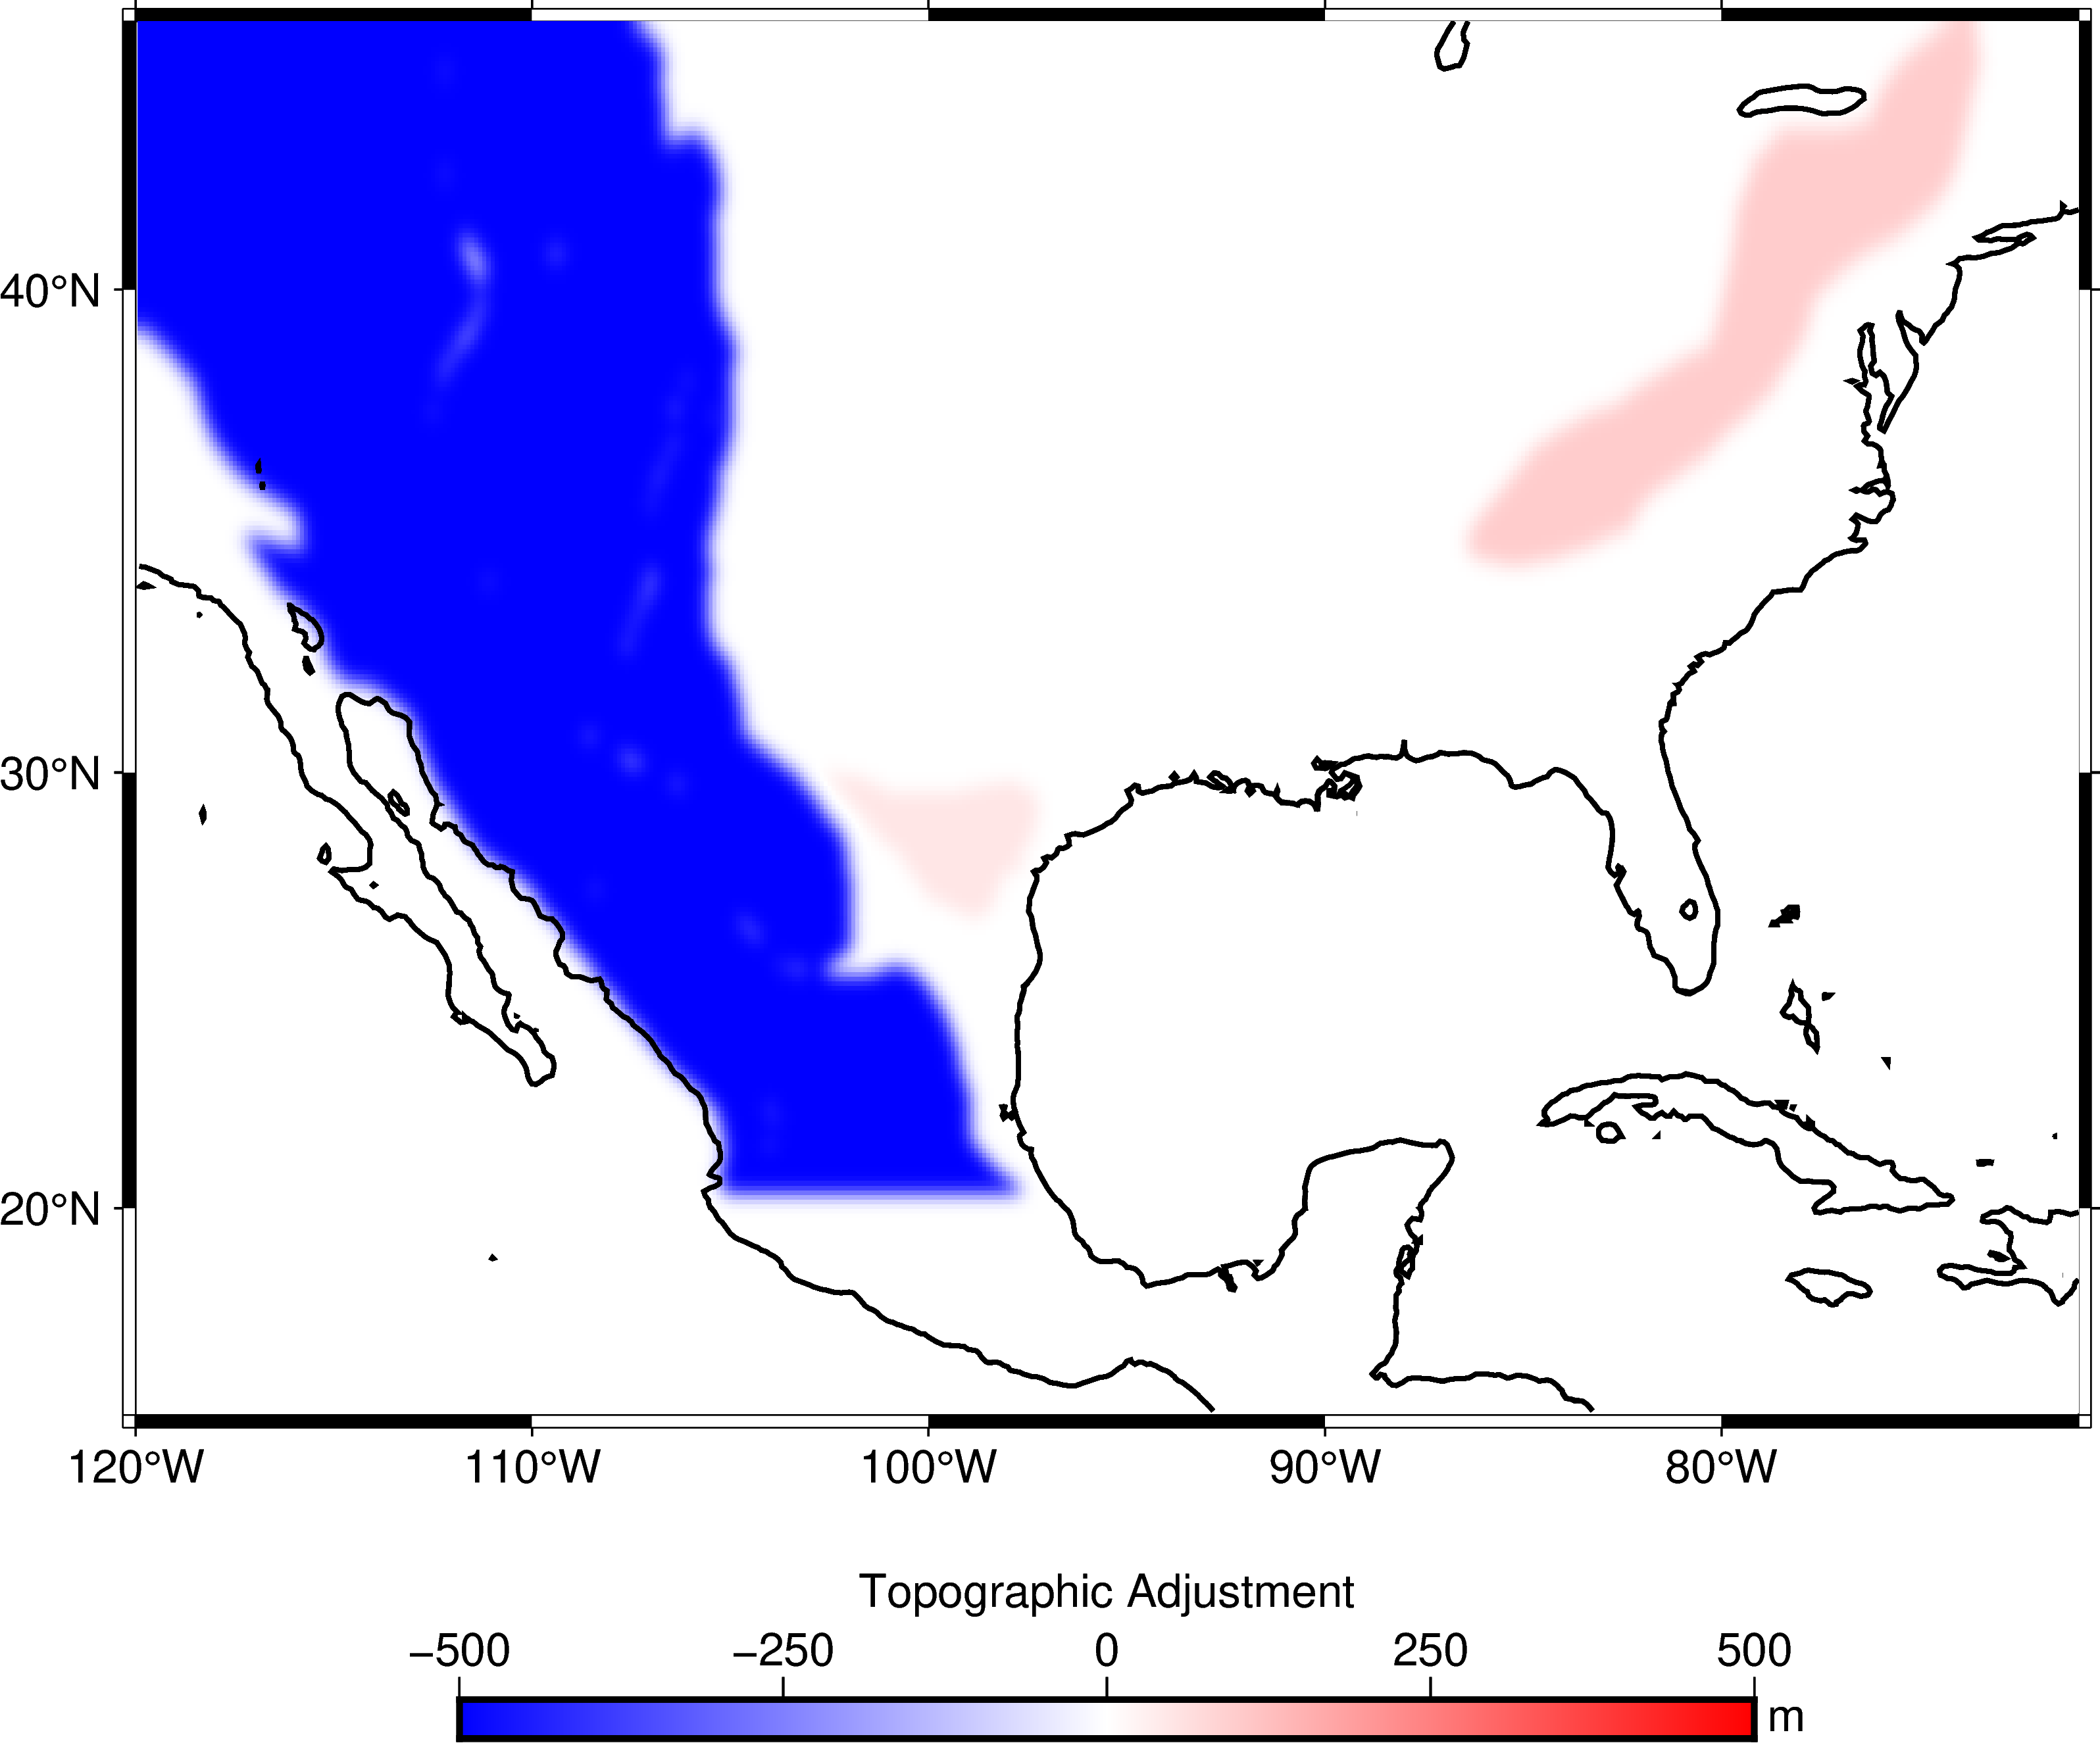

In [14]:
fname = "inputs/GPlates/topo_readjustement.gpml"
lonlat, val = isinside.dataGPML(fname, key="m")
top = isinside.contour2map(points, lonlat, val, clipshape, sigma=2)

# Let's store it in the xarray dataset
clipped["topadjust"]=(['lat', 'lon'],  top)

fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black', COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="polar", series=[-500, 500])
    fig.basemap(region=region, projection='M15c', frame='a')    
    fig.grdimage(clipped.topadjust, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=clipped.elevation, limit=[-0.1, 0.1],pen='1.p')
    fig.colorbar(frame=["a250", 'x+l"Topographic Adjustment"', "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
fig.show(dpi=500, width=600)

## Save local forcing

We save the forcing that was created above in a `netcdf` file that will then be used to build our `goSPL` input files.

In [15]:
clipped

<xarray.Dataset>
Dimensions:     (lon: 490, lat: 300)
Coordinates:
  * lon         (lon) float64 -119.9 -119.8 -119.7 -119.6 ... -71.2 -71.1 -71.0
  * lat         (lat) float64 15.1 15.2 15.3 15.4 15.5 ... 44.7 44.8 44.9 45.0
Data variables: (12/22)
    elevation   (lat, lon) float32 -4.218e+03 -4.192e+03 ... 579.8 553.5
    DT0Ma       (lat, lon) float32 587.2 586.9 586.6 ... -402.8 -402.6 -402.3
    DT1Ma       (lat, lon) float32 587.2 586.9 586.7 ... -403.3 -403.0 -402.8
    DT2Ma       (lat, lon) float32 587.3 586.9 586.5 ... -403.8 -403.5 -403.2
    DT3Ma       (lat, lon) float32 587.2 586.8 586.3 ... -404.2 -403.9 -403.6
    DT4Ma       (lat, lon) float32 587.0 586.5 585.9 ... -404.5 -404.2 -403.9
    ...          ...
    DT15Ma      (lat, lon) float32 566.9 565.9 564.8 ... -409.2 -408.8 -408.3
    DT16Ma      (lat, lon) float32 563.9 562.8 561.7 ... -409.6 -409.1 -408.6
    accuSedMio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    accuSed     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tectonic    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 27.0 27.0 27.0 27.0
    topadjust   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [17]:
clipped.to_netcdf('clipped.nc')